In [1]:
from face_verifier import get_person_descriptor, transform_descriptor, \
    load_pipe, load_people_centroids, calc_distance

In [2]:
import cv2
import dlib

import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN, KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
import skvideo.io

from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import rcParams

from tqdm import tqdm

import glob
import json
import pickle
from os.path import join, basename, exists, dirname
from os import listdir, makedirs
from collections import defaultdict
from itertools import product
from functools import partial

%matplotlib inline

In [3]:
def find_closest_person(p_centroids, descriptor):
    all_centroids = [p_centroid['centroid'] for p_centroid in p_centroids]
    centroid_dists = list(map(partial(calc_distance, descriptor2=descriptor), all_centroids))
    closest_id = np.argmin(centroid_dists)

    dist = centroid_dists[closest_id]

    if dist > SIMILARITY_THRESHOLD:
        return False, ''  # there is no person with similar descriptor
    else:
        person_name = p_centroids[closest_id]['name']
        return True, person_name

def find_person(img, cnn_face_detector, facerec, sp, pipe, p_centroids):
    face_descriptor = get_person_descriptor(img, cnn_face_detector, sp, facerec)
    descriptor = transform_descriptor(face_descriptor, pipe)
    is_found, person_name = find_closest_person(p_centroids, descriptor)

    return is_found, person_name

In [4]:
CURRENT_DIR = '.'
PREDICTOR_PATH = CURRENT_DIR + '/models/shape_predictor_68_face_landmarks.dat'
FACE_RECOGNITION_MODEL = CURRENT_DIR + '/models/dlib_face_recognition_resnet_model_v1.dat'
FACE_DETECTION_MODEL = CURRENT_DIR + '/models/mmod_human_face_detector.dat'
PEOPLE_CENTROIDS_PATH = CURRENT_DIR + '/faces_db/centroids.json'
PIPE_PATH = CURRENT_DIR + '/faces_db/pipe.pickle'

In [5]:
sp = dlib.shape_predictor(PREDICTOR_PATH)
facerec = dlib.face_recognition_model_v1(FACE_RECOGNITION_MODEL)
cnn_face_detector = dlib.cnn_face_detection_model_v1(FACE_DETECTION_MODEL)
pipe = load_pipe(PIPE_PATH)
p_centroids = load_people_centroids(PEOPLE_CENTROIDS_PATH)

In [6]:
rcParams['figure.figsize'] = (15, 15)

In [7]:
def draw_all_detected_faces(img, dets, color):
    dst = img.copy()
    for d in dets:
        cv2.rectangle(dst, (d[0], d[1]), (d[2], d[3]), color, 5)
    
    return dst

def draw_recognized_face(img, det, person_name, color):
    dst = img.copy()
    cv2.rectangle(dst, (det[0], det[1]), (det[2], det[3]), color, 5)
    cv2.putText(dst, person_name.upper(), (det[0], det[1] - 15), cv2.FONT_HERSHEY_SIMPLEX, 2, color, thickness=5)
    
    return dst

In [8]:
KNOWN_COLOR = (0, 255, 0)
UNKNOWN_COLOR = (255, 0, 0)
JUST_COLOR = (255, 255, 255)

In [9]:
def detect_faces_video(detector, video_path, out_path):
    cap = cv2.VideoCapture(video_path)
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    h, w = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)), int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    if h < w:
        out = cv2.VideoWriter(out_path, fourcc, cap.get(cv2.CAP_PROP_FPS), (w, h)[::-1])
    else:
        out = cv2.VideoWriter(out_path, fourcc, cap.get(cv2.CAP_PROP_FPS), (w, h))
    
    n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    for i in tqdm(range(n_frames)):
        ok, frame = cap.read()

        if not ok:
            break

        frame = frame[..., ::-1]
        if h < w:
            frame = frame.transpose((1, 0, 2))
        
        dets = detector(frame, 1)
        dets = [d.rect for d in dets]
        dst = draw_detected_faces(frame, dets)

        out.write(dst[..., ::-1])

    out.release()
    cap.release()

In [10]:
def recognize_faces_video(video_path, out_path):
    cap = cv2.VideoCapture(video_path)
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    h, w = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)), int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    if h < w:
        out = cv2.VideoWriter(out_path, fourcc, cap.get(cv2.CAP_PROP_FPS), (w, h)[::-1])
    else:
        out = cv2.VideoWriter(out_path, fourcc, cap.get(cv2.CAP_PROP_FPS), (w, h))
    
    n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    for i in tqdm(range(n_frames)):
        ok, frame = cap.read()

        if not ok:
            break

        frame = frame[..., ::-1]
        if h < w:
            frame = frame.transpose((1, 0, 2))
        
        dst = recognized_and_draw(frame)

        out.write(dst[..., ::-1])

    out.release()
    cap.release()

### Record videos with face names

In [11]:
def recognized_and_draw(img):
    dets = cnn_face_detector(img, 1)
    dets = [(d.rect.left(), d.rect.top(), d.rect.right(), d.rect.bottom()) for d in dets]

    try:
        is_found, person_name = find_person(img, cnn_face_detector, facerec, sp, pipe, p_centroids)
        if is_found:
            dst = draw_recognized_face(img, dets[0], person_name, KNOWN_COLOR)
        else:
            dst = img.copy()
            for det in dets:
                dst = draw_recognized_face(img, det, 'unknown', UNKNOWN_COLOR)
    except Exception as e:
        print(e)
        dst = draw_all_detected_faces(img, dets, JUST_COLOR)
    
    return dst

In [12]:
SIMILARITY_THRESHOLD = 0.3

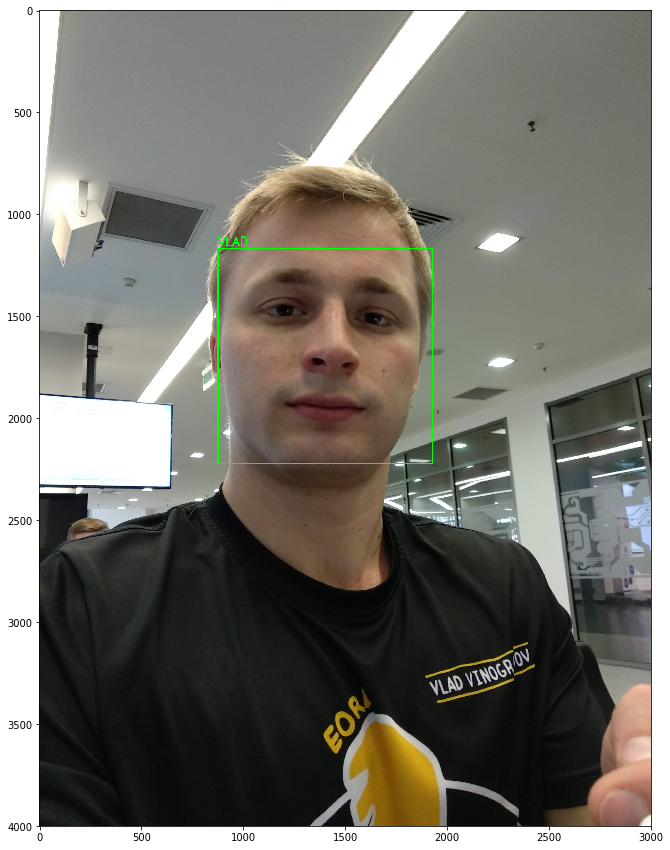

In [13]:
# cap = cv2.VideoCapture(video_paths[3])
# cap = cv2.VideoCapture('../data/faces/known/anton.mp4')
# n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
# cap.set(1, 40)

# _, img = cap.read()
# cap.release()

# img = img[..., ::-1]
# img = img.transpose((1, 0, 2))

img = cv2.imread('../data/faces/real_photos/vlad.jpg')[..., ::-1]

dst = recognized_and_draw(img)

imshow(dst)

In [14]:
video_paths = [
    '../data/faces/unknown/unknown.mp4',
#     '../data/faces/known/anton.mp4',
    '../data/faces/known/sergey.mp4',
    '../data/faces/known/ramil.mp4',
    '../data/faces/known/vlad.mp4'
]

In [15]:
# SIMILARITY_THRESHOLD = 0.2
# video_path = video_paths[0]
# out_path = join('../data/faces/demos/', basename(video_path))
# recognize_faces_video(video_path, out_path)

100%|██████████| 166/166 [03:35<00:00,  1.30s/it]


In [16]:
for i, video_path in enumerate(video_paths):
    print('Video {}/{}'.format(i + 1, len(video_paths)))
    out_path = join('../data/faces/demos/', basename(video_path))
    recognize_faces_video(video_path, out_path)

  0%|          | 0/166 [00:00<?, ?it/s]

Video 1/4


  0%|          | 0/211 [00:00<?, ?it/s]

Video 2/4


  0%|          | 0/141 [00:00<?, ?it/s]

Video 3/4


  0%|          | 0/233 [00:00<?, ?it/s]

Video 4/4


100%|██████████| 233/233 [02:38<00:00,  1.47it/s]


In [26]:
video_paths = [
    '../data/faces/demos/anton.mp4',
    '../data/faces/demos/unknown.mp4'
#     '../data/faces/demos/sergey.mp4',
#     '../data/faces/demos/ramil.mp4',
]

In [27]:
out_path = '../data/faces/demos/two_persons.mp4'

caps = []
sizes = []
min_n_frames = 1000000
for video_path in video_paths:
    cap = cv2.VideoCapture(video_path)
    caps.append(cap)
    n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    h, w = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)), int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    sizes.append((h, w))
    if n_frames < min_n_frames:
        min_n_frames = n_frames

cap = caps[0]
fourcc = cv2.VideoWriter_fourcc(*'XVID')
h, w = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)), int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
if h < w:
    w *= len(caps)
    out = cv2.VideoWriter(out_path, fourcc, cap.get(cv2.CAP_PROP_FPS), (w, h)[::-1])
else:
    w *= len(caps)
    out = cv2.VideoWriter(out_path, fourcc, cap.get(cv2.CAP_PROP_FPS), (w, h))

for i in tqdm(range(min_n_frames)):
    imgs = [cap.read()[1][..., ::-1] for cap in caps]
    imgs = [img.transpose(1, 0, 2) if size[0] < size[1] else img for size, img in zip(sizes, imgs)]
    dst = np.hstack(imgs)
    out.write(dst[..., ::-1])
    
out.release()
for cap in caps:
    cap.release()

100%|██████████| 166/166 [00:08<00:00, 19.38it/s]
